In [1]:
%matplotlib inline

In [2]:
import numpy as np
import xarray as xr
import pandas as pd

import scipy.spatial
import scipy.linalg

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.sandbox.stats.multicomp as smm
import statsmodels.tsa.stattools as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt
import seaborn as sns
#current_palette = sns.color_palette("hls", 8)
#sns.set_palette(current_palette)

In [3]:
# Load the data
# wget ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G10010/G10010_SIBT1850_v1.1.zip
nc = xr.open_dataset('data/G10010_SIBT1850_v1.1.nc')

In [4]:
# Average out years
yr_avg = nc.seaice_conc.groupby('time.year').mean()

# Separate into seasons
seasons = nc.seaice_conc.groupby('time.season').mean('latitude').mean('longitude')
seas_df = seasons.to_dataframe()
seas_df = seas_df.groupby([lambda x: x.year, 'season']).mean()
seas_df = seas_df.reset_index()

djf_df = seas_df.loc[seas_df['season'] == 'DJF']
jja_df = seas_df.loc[seas_df['season'] == 'JJA']
mam_df = seas_df.loc[seas_df['season'] == 'MAM']
son_df = seas_df.loc[seas_df['season'] == 'SON']

djf_df.reset_index(inplace=True)
jja_df.reset_index(inplace=True)
mam_df.reset_index(inplace=True)
son_df.reset_index(inplace=True)

del djf_df['index']
del jja_df['index']
del mam_df['index']
del son_df['index']

djf_df.columns = ['year', 'season', 'seaice_conc']
jja_df.columns = ['year', 'season', 'seaice_conc']
mam_df.columns = ['year', 'season', 'seaice_conc']
son_df.columns = ['year', 'season', 'seaice_conc']

del djf_df['season']
del jja_df['season']
del mam_df['season']
del son_df['season']

In [5]:
seasons = ['JJA', 'SON', 'DJF', 'MAM']
dfs = {'DJF': djf_df, 'JJA': jja_df, 'MAM': mam_df, 'SON': son_df}

In [6]:
cmap = {'JJA': 'crimson', 'SON': 'darkorange', 'DJF': 'steelblue', 'MAM': 'seagreen'}

## Arctic splines

Since the arctic sea data set is such a long time series, we'll compute linear splines to get a piecewise trend of the data.

#### Definitions:

* A **linear spline** is a continuous function formed by connecting linear
segments.  The points where the segments connect are called the
**knots** of the spline.

* A **spline of degree** $D$ is a function formed by connecting polynomial segments
of degree $D$ so that:
    * the function is continuous,
    * the function has $D-1$ continuous derivatives,
    * the $D^{\text{th}}$ derivative is constant between knots

* The **truncated polynomial** of degree $D$ associated with knot $\xi_{k}$ is the function which is equal to $0$ to the left of $\xi_{k}$ and equal to $(x-\xi_{k})^D$ to the right of $\xi_{k}$.

$$(x-\xi_{k})_{+}^D = 
\begin{cases}
(x-\xi_{k})^D, & \text{if $x \geq \xi_{k}$} \\
0, & \text{if $x \lt \xi_{k}$}
\end{cases}
$$


#### Equation of spline of degree $D$ and $K$ knots:

$$y = \beta_{0} + \sum_{d=1}^{D}\beta_{d}x_{d} + \sum_{k=1}^{K}\alpha_{k}(x-\xi_{k})_{+}^D$$

#### Design Matrix:
$$
\mathbf{X} = 
\begin{bmatrix}
1 & x_1 & x_{1}^{2} & \dots & x_{1}^{D} & (x_{1}-\xi_{1})_{+}^D & \dots & (x_{1}-\xi_{K})_{+}^D \\
1 & x_2 & x_{2}^{2} & \dots & x_{2}^{D} & (x_{2}-\xi_{1})_{+}^D & \dots & (x_{2}-\xi_{K})_{+}^D \\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \ddots & \vdots \\
1 & x_n & x_{n}^{2} &\dots & x_{n}^{D} & (x_{n}-\xi_{1})_{+}^D & \dots & (x_{n}-\xi_{K})_{+}^D
\end{bmatrix}
$$

In [7]:
def linear_splines(data, knots, degree=1):
    minyr = data.year.min()
    nyrs = data.year.shape[0]

    # Use indices of years for knots
    minyr = data.year.min()
    knots2 = [k-minyr for k in knots]
    
    # Column vector for beta1 are (t1, t2,...,tn)
    X1 = np.arange(nyrs)
    X1 = X1[:, np.newaxis]
    
    # Generate design matrix
    X2 = np.zeros((nyrs, len(knots2)))
    for col, k in enumerate(knots2):
        X2[k:, col] = np.abs(X2[k:, col] - X1[:nyrs-k, 0])
    X = np.hstack((X1, X2))
    return smf.glm('seaice_conc ~ X', data=data).fit()

### Knots for Arctic sea

From the explore_seaice notebook, the trends look peicewise with possible knots at various locations. We'll define our set of knots for each season:

$$
K_{\text{JJA}} = \{1917, 1944, 1996\}\\
K_{\text{SON}} = \{1917, 1943, 1996\}\\
K_{\text{DJF}} = \{1974, 1996\}\\
K_{\text{MAM}} = \{1933, 1979\}
$$

We'll plot the knots to visually check

In [8]:
# Define the knots
jjaknots = [1917, 1944, 1996]
#jjaknots2 = [1893, 1899, 1917, 1943, 1996]
sonknots = [1917, 1943, 1996]
djfknots = [1974, 1996]
mamknots = [1933, 1979]

splines = {'JJA': linear_splines(jja_df, jjaknots),
           'SON': linear_splines(son_df, sonknots),
           'DJF': linear_splines(djf_df, djfknots),
           'MAM': linear_splines(mam_df, mamknots)}

In [9]:
def plot_splines(yrs, conc, preds, label, season=None, ax=None, col='g'):
    if ax is None:
        ax = plt.gca()
    spl = ax.plot(yrs, conc, alpha=0.3, color='k')
    ax.plot(yrs, preds, label=label, color=col)
    ax.legend()
    ax.set_xlim(1845, 2016)
    #ax.set_ylim(17.5, 26)
    ax.set_xlabel('years')
    ax.set_ylabel('seaice_conc')
    ax.set_title('Linear Splines for {}'.format(season))
    return spl

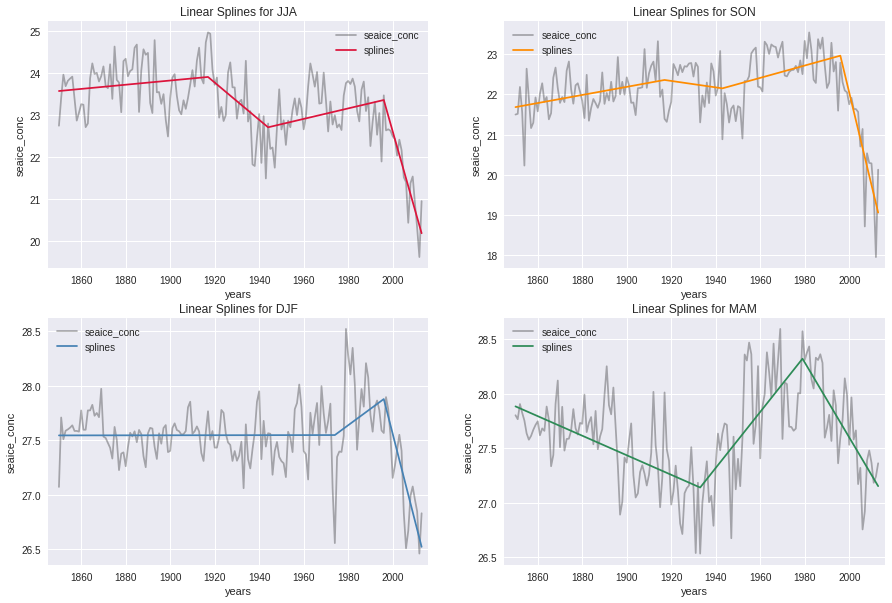

In [10]:
f, axs = plt.subplots(2, 2, figsize=(15,10))
axs = np.array(axs)

for i, ax in enumerate(axs.reshape(-1)):
    s = seasons[i]
    yr = dfs[s].year
    conc = dfs[s].seaice_conc
    preds = splines[s].fittedvalues
    plot_splines(yr, conc, preds, 'splines', season=s, ax=ax, col=cmap[s])

Visually the splines look reasonable. However, let's test the significance of each spline and remove the splines that are not significicant with a significance level, $\alpha = 0.05$

We'll use Bonferroni's correction for multiple tests.

In [11]:
nyrs = yr_avg.shape[0]
#nparams = len(knots) + 2

# Estimates
mu_hat = {season: spl.mu for season, spl in splines.items()}
R = {season: spl.resid_response.values for season, spl in splines.items()}
cov = {season: spl.cov_params() for season, spl in splines.items()}
#sigma_hat2 = {season: np.sum(r**2) / (nyrs-nparams) for season, r in R.items()}
pvals = {season: spl.pvalues.values for season, spl in splines.items()}

In [12]:
bonferonnis = {season: (smm.multipletests(pval, method='bonferroni')[:2])
               for season, pval in pvals.items()}

In [13]:
for season, test in bonferonnis.items():
    print('{}: {}'.format(season, test[0]))

JJA: [ True False  True  True  True]
SON: [ True  True False False  True]
DJF: [ True False  True  True]
MAM: [ True  True  True  True]


We see some splines are not significant. We'll remove those and recompute our model. Our new knots are now:

$$
K_{\text{JJA}} = \{1944, 1996\}\\
K_{\text{SON}} = \{1917, 1996\}\\
K_{\text{DJF}} = \{1996\}\\
K_{\text{MAM}} = \{1933, 1979\}
$$


In [14]:
# Splines with new knots... Pt.2
jjaknots2 = [1944, 1996]
sonknots2 = [1917, 1996]
djfknots2 = [1996]
mamknots2 = [1933, 1979]

splines2 = {'JJA': linear_splines(jja_df, jjaknots2),
           'SON': linear_splines(son_df, sonknots2),
           'DJF': linear_splines(djf_df, djfknots2),
           'MAM': linear_splines(mam_df, mamknots2)}

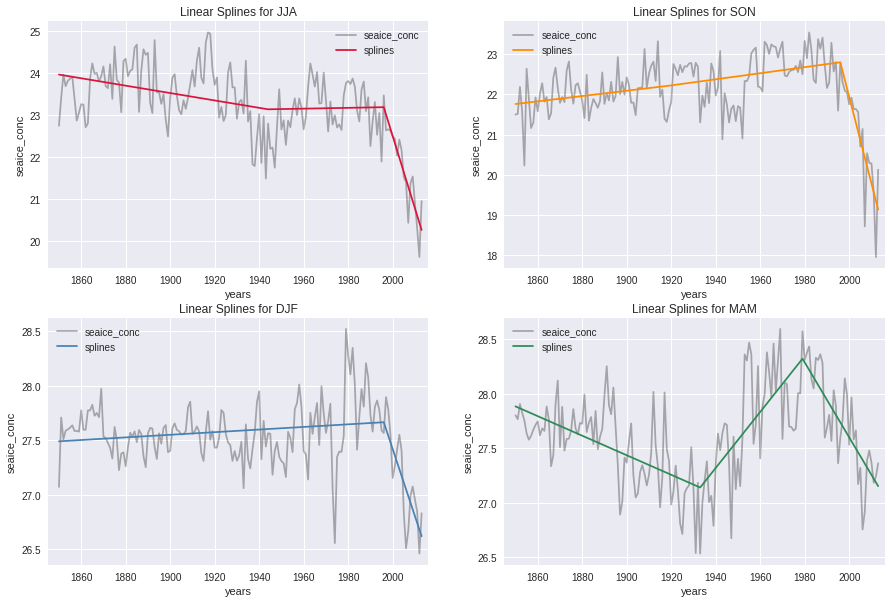

In [15]:
f, axs = plt.subplots(2, 2, figsize=(15,10))
axs = np.array(axs)

for i, ax in enumerate(axs.reshape(-1)):
    s = seasons[i]
    yr = dfs[s].year
    conc = dfs[s].seaice_conc
    preds = splines2[s].fittedvalues
    plot_splines(yr, conc, preds, 'splines', season=s, ax=ax, col=cmap[s])

In [16]:
# Estimates Pt.2
mu_hat2 = {season: spl.mu for season, spl in splines2.items()}
R2 = {season: spl.resid_response.values for season, spl in splines2.items()}
cov2 = {season: spl.cov_params() for season, spl in splines2.items()}
pvals2 = {season: spl.pvalues.values for season, spl in splines2.items()}

bonferonnis2 = {season: (smm.multipletests(pval, method='bonferroni')[:2])
               for season, pval in pvals2.items()}

for season, test in bonferonnis2.items():
    print('{}: {}'.format(season, test[0]))

JJA: [ True  True False  True]
SON: [ True  True False  True]
DJF: [ True  True  True]
MAM: [ True  True  True  True]


Once again, we see some splines that don't make the cut. We'll remove those, and recompute our model. Our knots are now:

$$
K_{\text{JJA}} = \{1996\}\\
K_{\text{SON}} = \{1996\}\\
K_{\text{DJF}} = \{1996\}\\
K_{\text{MAM}} = \{1933, 1979\}
$$


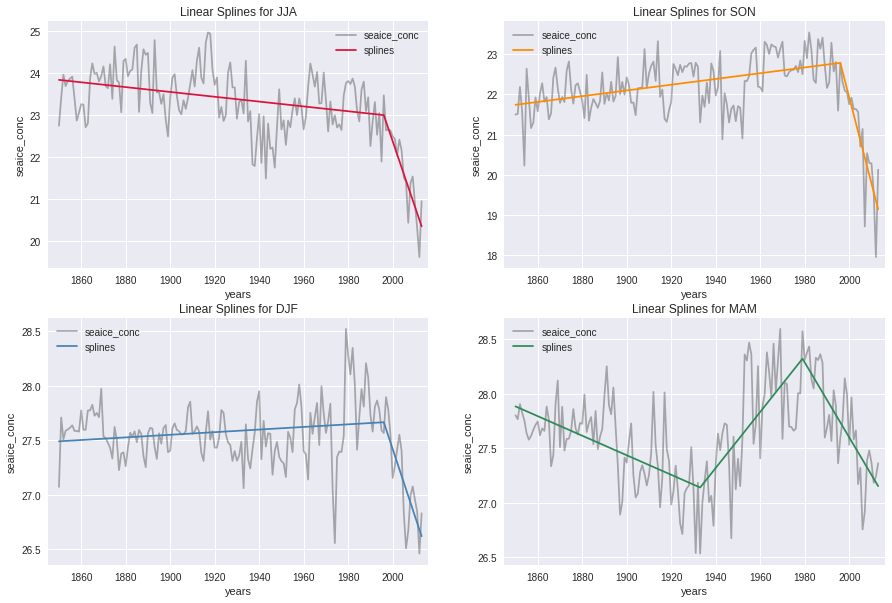

In [17]:
# Estimates Pt.3
jjaknots3 = [1996]
sonknots3 = [1996]
djfknots3 = [1996]
mamknots3 = [1933, 1979]

splines3 = {'JJA': linear_splines(jja_df, jjaknots3),
           'SON': linear_splines(son_df, sonknots3),
           'DJF': linear_splines(djf_df, djfknots3),
           'MAM': linear_splines(mam_df, mamknots3)}

f, axs = plt.subplots(2, 2, figsize=(15,10))
axs = np.array(axs)

for i, ax in enumerate(axs.reshape(-1)):
    s = seasons[i]
    yr = dfs[s].year
    conc = dfs[s].seaice_conc
    preds = splines3[s].fittedvalues
    plot_splines(yr, conc, preds, 'splines', season=s, ax=ax, col=cmap[s])

In [18]:
# Bonferonnis Pt.3
mu_hat3 = {season: spl.mu for season, spl in splines3.items()}
R3 = {season: spl.resid_response.values for season, spl in splines3.items()}
cov3 = {season: spl.cov_params() for season, spl in splines3.items()}
pvals3 = {season: spl.pvalues.values for season, spl in splines3.items()}

bonferonnis3 = {season: (smm.multipletests(pval, method='bonferroni')[:2])
               for season, pval in pvals3.items()}

for season, test in bonferonnis3.items():
    print('{}: {}'.format(season, test[0]))

JJA: [ True  True  True]
SON: [ True  True  True]
DJF: [ True  True  True]
MAM: [ True  True  True  True]


Finally! We have a set of knots that are significant.

### Plot ACFs and PACFs of the residiuals for each season

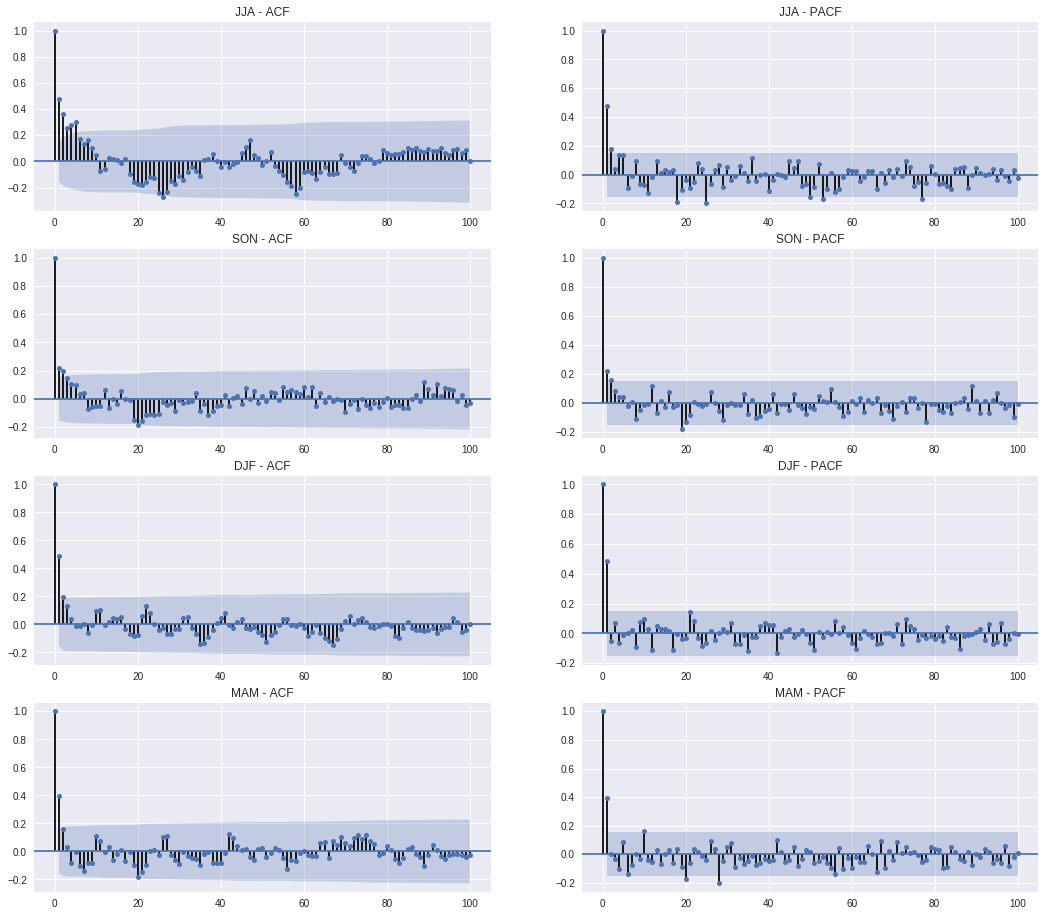

In [19]:
# Plot ACFs and PACFs
f, axs = plt.subplots(4, 2, figsize=(18,16))

jja_acf = plot_acf(R3['JJA'], lags=100, title ='JJA - ACF', ax=axs[0,0])
jja_pacf = plot_pacf(R3['JJA'], lags=100, title='JJA - PACF', ax=axs[0,1])

son_acf = plot_acf(R3['SON'], lags=100, title='SON - ACF', ax=axs[1,0])
son_pacf = plot_pacf(R3['SON'], lags=100, title='SON - PACF', ax=axs[1,1])

djf_acf = plot_acf(R3['DJF'], lags=100, title='DJF - ACF', ax=axs[2,0])
djf_pacf = plot_pacf(R3['DJF'], lags=100, title='DJF - PACF', ax=axs[2,1])

mam_acf = plot_acf(R3['MAM'], lags=100, title='MAM - ACF', ax=axs[3,0])
mam_pacf = plot_pacf(R3['MAM'], lags=100, title='MAM - PACF', ax=axs[3,1])

In [20]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

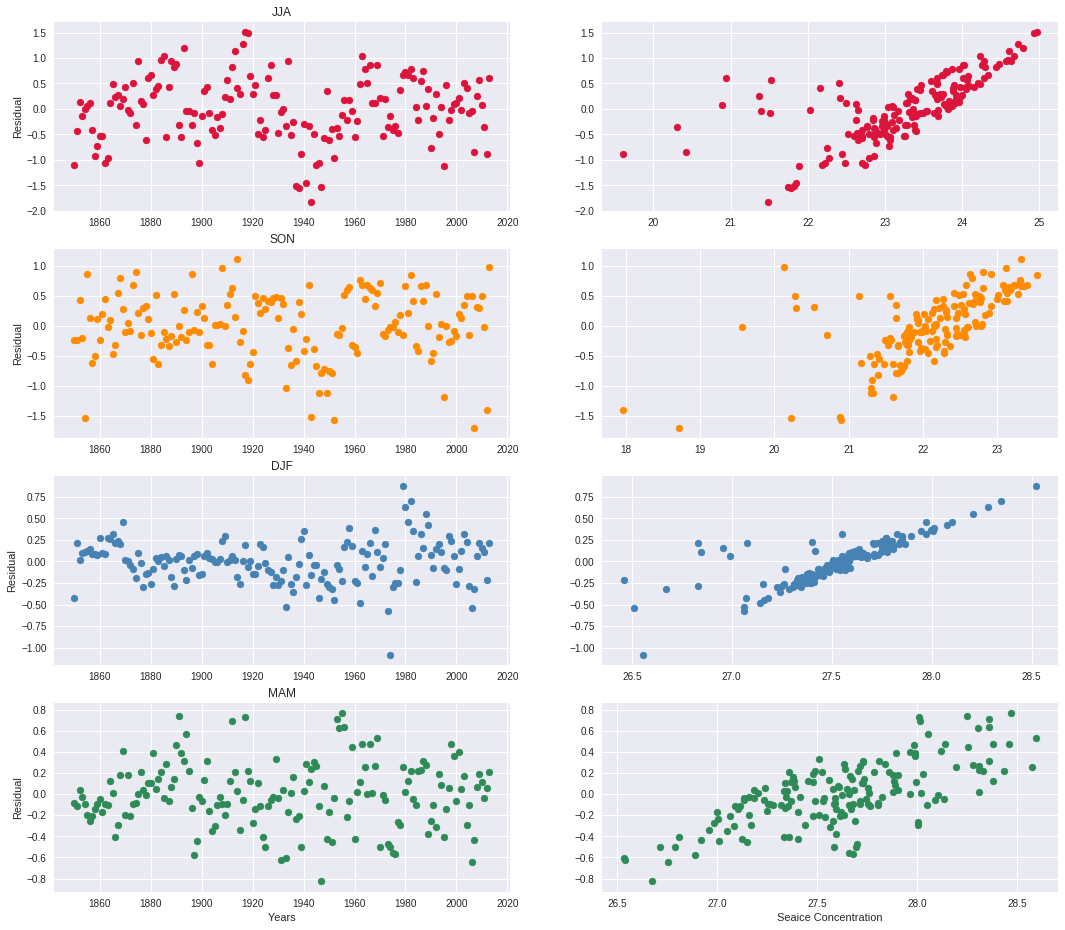

In [21]:
f, axr = plt.subplots(4, 2, figsize=(18,16))

axr[0,0].scatter(jja_df.year, R3['JJA'], color=cmap['JJA'])
axr[0,0].set_ylabel('Residual')
axr[0,0].set_title('JJA')
axr[0,1].scatter(jja_df.seaice_conc, R3['JJA'], color=cmap['JJA'])

axr[1,0].scatter(son_df.year, R3['SON'], color=cmap['SON'])
axr[1,0].set_ylabel('Residual')
axr[1,0].set_title('SON')
axr[1,1].scatter(son_df.seaice_conc, R3['SON'], color=cmap['SON'])

axr[2,0].scatter(djf_df.year, R3['DJF'], color=cmap['DJF'])
axr[2,0].set_ylabel('Residual')
axr[2,0].set_title('DJF')
axr[2,1].scatter(djf_df.seaice_conc, R3['DJF'], color=cmap['DJF'])

axr[3,0].scatter(mam_df.year, R3['MAM'], color=cmap['MAM'])
axr[3,0].set_ylabel('Residual')
axr[3,0].set_title('MAM')
axr[3,1].scatter(mam_df.seaice_conc, R3['MAM'], color=cmap['MAM'])

axr[3,0].set_xlabel('Years')
axr[3,1].set_xlabel('Seaice Concentration')

In [22]:
# Compute FFT of the residuals
# Take the periodogram (abs(R)^2)
# Plot the periodogram

In [23]:
ffts = {season: np.fft.fft(resid) for season, resid in R3.items()}
periodograms = {season: np.abs(fftr)**2 for season, fftr in ffts.items()}

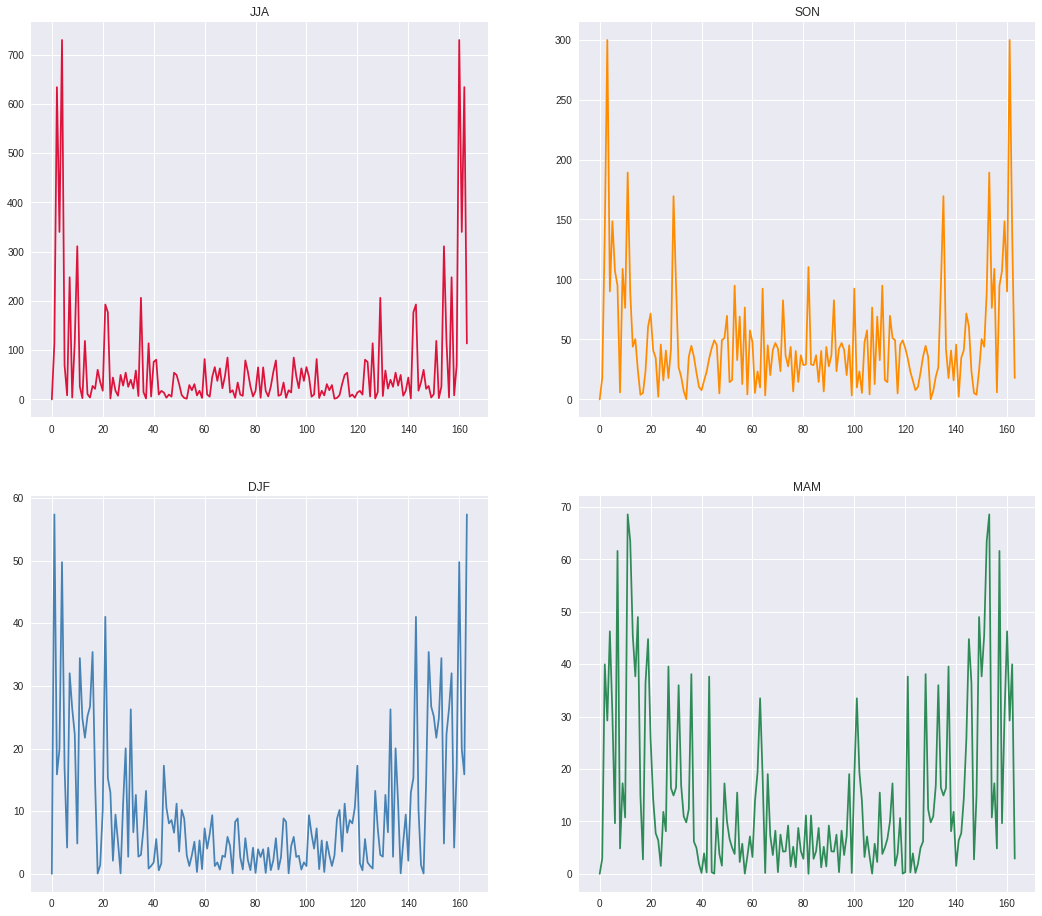

In [24]:
f, ax = plt.subplots(2, 2, figsize=(18,16))

ax[0,0].plot(periodograms['JJA'], color=cmap['JJA'])
ax[0,0].set_title('JJA')

ax[0,1].plot(periodograms['SON'], color=cmap['SON'])
ax[0,1].set_title('SON')

ax[1,0].plot(periodograms['DJF'], color=cmap['DJF'])
ax[1,0].set_title('DJF')

ax[1,1].plot(periodograms['MAM'], color=cmap['MAM'])
ax[1,1].set_title('MAM')

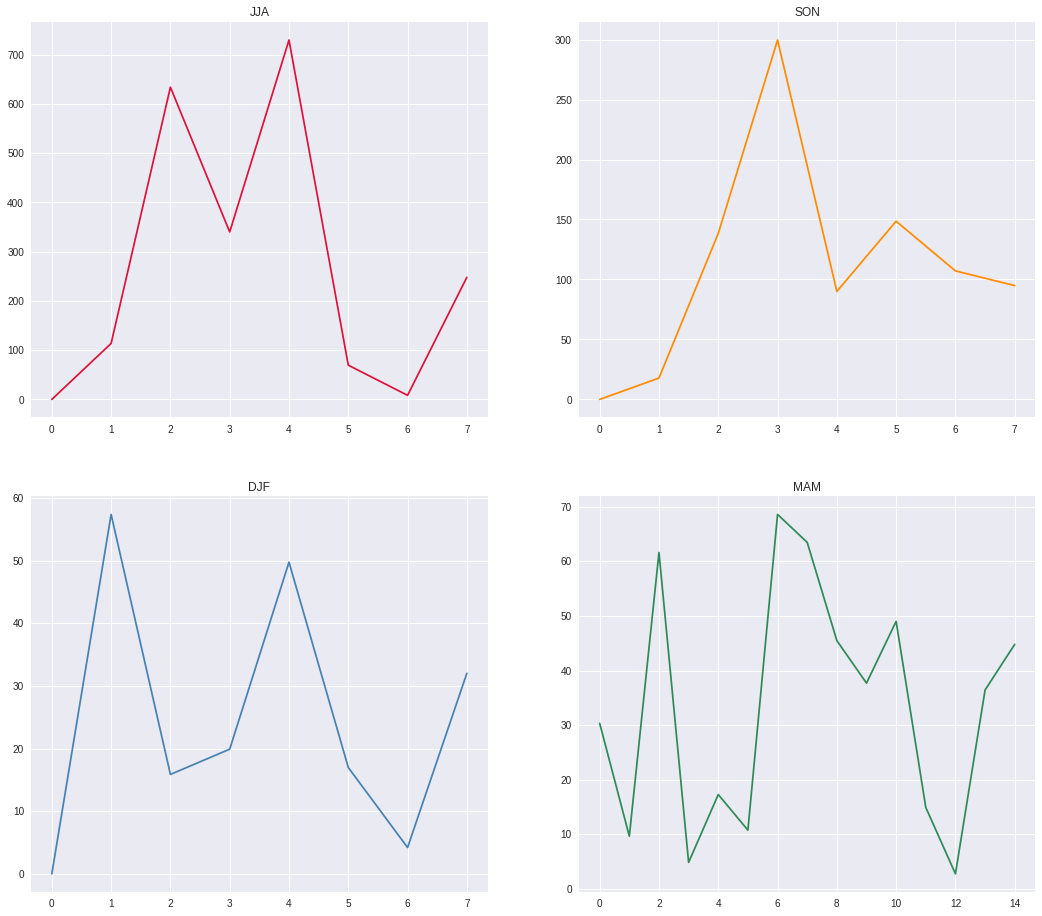

In [25]:
f, ax = plt.subplots(2, 2, figsize=(18,16))

ax[0,0].plot(periodograms['JJA'][:8], color=cmap['JJA'])
ax[0,0].set_title('JJA')

ax[0,1].plot(periodograms['SON'][:8], color=cmap['SON'])
ax[0,1].set_title('SON')

ax[1,0].plot(periodograms['DJF'][:8], color=cmap['DJF'])
ax[1,0].set_title('DJF')

ax[1,1].plot(periodograms['MAM'][5:20], color=cmap['MAM'])
ax[1,1].set_title('MAM')

In [26]:
y_jja = jja_df.seaice_conc.values
y_son = son_df.seaice_conc.values
y_djf = djf_df.seaice_conc.values
y_mam = mam_df.seaice_conc.values

t1 = yr_avg.year.values

In [183]:
nyrs = t1.max() - t1.min() + 1

sin_jja = np.array([np.sin(2*np.pi*2 * (t/nyrs)) for t in np.arange(nyrs)])
cos_jja = np.array([np.cos(2*np.pi*2 * (t/nyrs)) for t in np.arange(nyrs)])

sin_son = np.array([np.sin(2*np.pi*3 * (t/nyrs)) for t in np.arange(nyrs)])
cos_son = np.array([np.cos(2*np.pi*3 * (t/nyrs)) for t in np.arange(nyrs)])

sin_djf = np.array([np.sin(2*np.pi*1 * (t/nyrs)) for t in np.arange(nyrs)])
cos_djf = np.array([np.cos(2*np.pi*1 * (t/nyrs)) for t in np.arange(nyrs)])

sin_mam = np.array([np.sin(2*np.pi*6 * (t/nyrs)) for t in np.arange(nyrs)])
cos_mam = np.array([np.cos(2*np.pi*6 * (t/nyrs)) for t in np.arange(nyrs)])

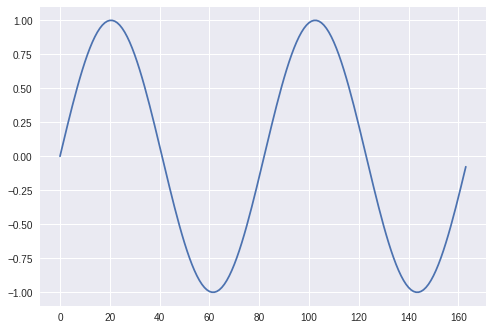

In [186]:
plt.plot(sin_jja)

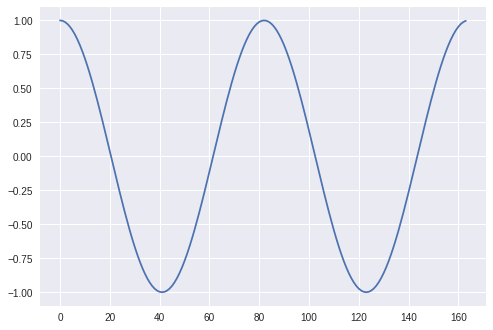

In [187]:
plt.plot(cos_jja)

In [96]:
import rpy2.robjects as robjs
from rpy2.robjects.packages import importr
from IPython.display import display
from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [97]:
# Import R packages in Python
r = robjs.r
nlme = importr('nlme')
stats = importr('stats')

### JJA

In [98]:
robjs.globalenv['y_jja'] = robjs.FloatVector(y_jja)
robjs.globalenv['t1'] = robjs.FloatVector(t1)

robjs.globalenv["sin_jja"] = robjs.FloatVector(sin_jja) # Add sine to R envrionment as FloatVector
robjs.globalenv["cos_jja"] = robjs.FloatVector(cos_jja) # Add cose to R envrionment as FloatVector

fit_jja = nlme.gls(r.formula("y_jja ~ sin_jja + cos_jja"), method='ML')
print(r.summary(fit_jja))

Generalized least squares fit by maximum likelihood
  Model: y_jja ~ sin_jja + cos_jja 
  Data: NULL 
       AIC      BIC    logLik
  414.7773 427.1768 -203.3887

Coefficients:
                Value  Std.Error  t-value p-value
(Intercept) 23.224777 0.06590995 352.3713  0.0000
sin_jja      0.083046 0.09321074   0.8909  0.3743
cos_jja     -0.471102 0.09321074  -5.0542  0.0000

 Correlation: 
        (Intr) sin_jj
sin_jja 0            
cos_jja 0      0     

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-3.75607851 -0.53527771  0.06881911  0.67495134  2.40423199 

Residual standard error: 0.8363035 
Degrees of freedom: 164 total; 161 residual



In [99]:
k_hat_jja = fit_jja.rx2('coefficients')  # extract fitted regression coefficients
print(k_hat_jja)
e_jja = np.array(fit_jja.rx2('residuals'))

(Intercept)     sin_jja     cos_jja 
23.22477668  0.08304604 -0.47110217 



In [188]:
print(np.mean(e_jja))


8.66515531415e-16


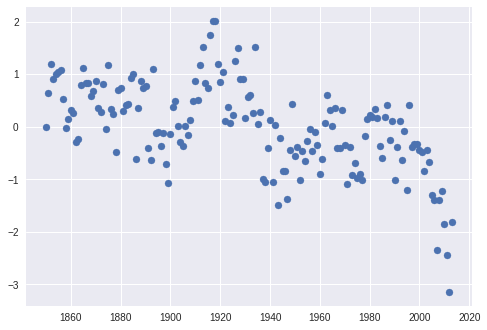

In [101]:
plt.scatter(jja_df.year, e_jja)

In [102]:
k_hat_jja

R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x7f82f29b5c88 / R:0x8b15e78>
[23.224777, 0.083046, -0.471102]

### Fit seasonal cycle with sine removed

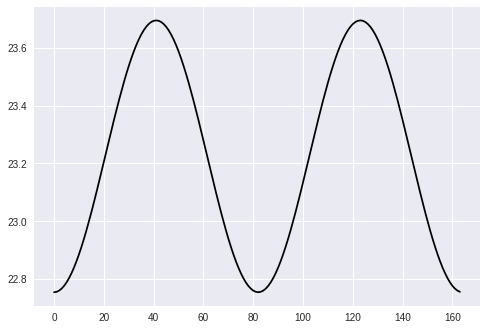

In [189]:
# fitted seasonal cycle
f_hat_jja = k_hat_jja[0] + k_hat_jja[2]*cos_jja  
plt.plot(f_hat_jja,'k-') 

In [193]:
# Remove residuals
f2 = R3['JJA'] - f_hat_jja
f2 = f2 - np.mean(f2)

In [194]:
import statsmodels.tsa.arima_model as arima

# Fit AR2 model
fit2 = arima.ARIMA(f2, (2,0,0)).fit()
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  164
Model:                     ARMA(2, 0)   Log Likelihood                -130.861
Method:                       css-mle   S.D. of innovations              0.537
Date:                Thu, 29 Jun 2017   AIC                            269.722
Time:                        17:57:52   BIC                            282.121
Sample:                             0   HQIC                           274.755
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.097      0.027      0.978      -0.188       0.194
ar.L1.y        0.3971      0.078      5.080      0.000       0.244       0.550
ar.L2.y        0.1771      0.078      2.266      0.025       0.024       0.330
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5064           +0.0000j            1.5064            0.0000
AR.2           -3.7483           +0.0000j            3.7483            0.5000
-----------------------------------------------------------------------------
"""

In [195]:
print(fit2.pvalues)
print(np.mean(f2))

[  9.78155387e-01   1.03587238e-06   2.47636454e-02]
4.33257765707e-16


In [196]:
# Remove fitted terms from residual to check for white noise
resid2 = fit2.resid
params = fit2.params

X1 = resid2[1:]
X2 = resid2[:-1]

X1 = X1[:, np.newaxis]
X2 = X2[:, np.newaxis]

X = np.hstack((X1, X2))
F = np.dot(X, params[1:])
ef = resid2[1:] - F

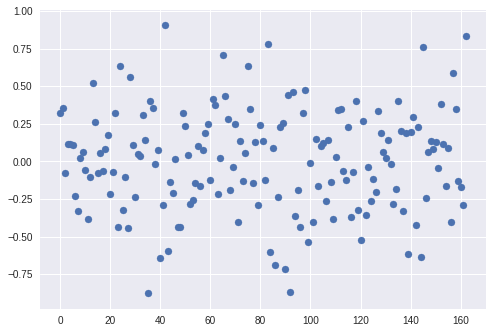

In [197]:
plt.scatter(np.arange(len(F)), ef)

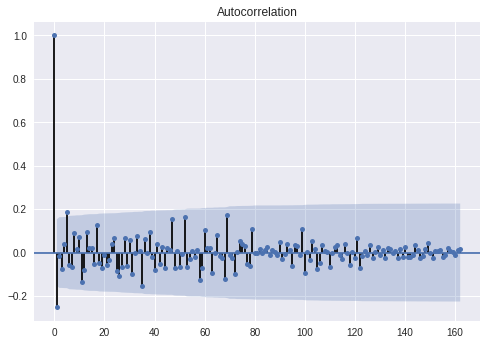

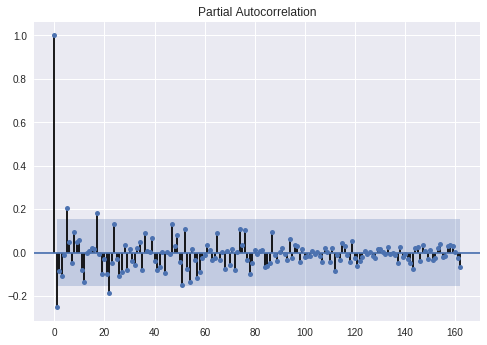

In [176]:
z1 = plot_acf(ef)
z2 = plot_pacf(ef)

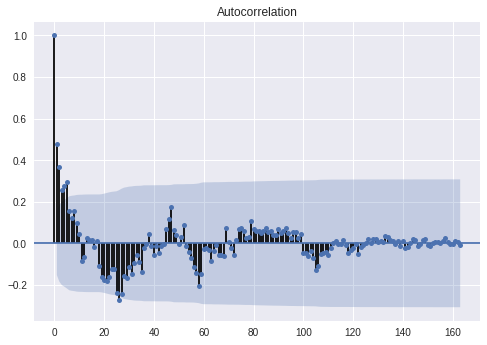

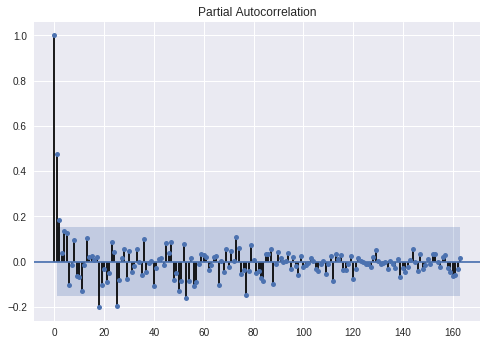

In [112]:
R2_jja = R3['JJA'] - f_hat_jja
jja2_acf = plot_acf(R2_jja)
jja2_pacf = plot_pacf(R2_jja)

### SON

In [55]:
robjs.globalenv['y_son'] = robjs.FloatVector(y_son)

robjs.globalenv["sinf_son"] = robjs.FloatVector(sinf_son) # Add sine to R envrionment as FloatVector
robjs.globalenv["cosf_son"] = robjs.FloatVector(cosf_son) # Add cose to R envrionment as FloatVector

fit_son = nlme.gls(r.formula("y_son ~ sinf_son + cosf_son"), method='ML')
print(r.summary(fit_son))

Generalized least squares fit by maximum likelihood
  Model: y_son ~ sinf_son + cosf_son 
  Data: NULL 
       AIC      BIC    logLik
  373.1908 385.5903 -182.5954

Coefficients:
                Value Std.Error   t-value p-value
(Intercept) -695.6196 116.47396 -5.972318       0
sinf_son      41.4287   6.91529  5.990873       0
cosf_son     716.9370 116.34652  6.162083       0

 Correlation: 
         (Intr) snf_sn
sinf_son -0.968       
cosf_son -1.000  0.968

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-4.62524173 -0.48026102  0.08984212  0.54975942  1.99547184 

Residual standard error: 0.7367166 
Degrees of freedom: 164 total; 161 residual



In [56]:
k_hat_son = fit_son.rx2('coefficients')  # extract fitted regression coefficients
print(k_hat_son)
e_son = np.array(fit_son.rx2('residuals'))

(Intercept)    sinf_son    cosf_son 
 -695.61955    41.42865   716.93698 



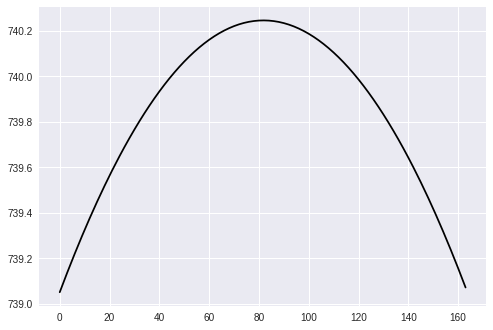

In [57]:
f_hat_son = np.mean(y_son) + k_hat_son[1]*sinf_son + k_hat_son[2]*cosf_son  # fitted seasonal cycle
plt.plot(f_hat_son,'k-') 

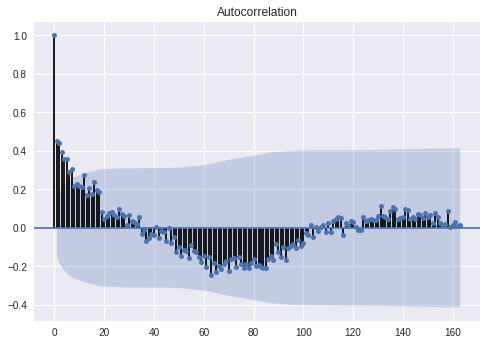

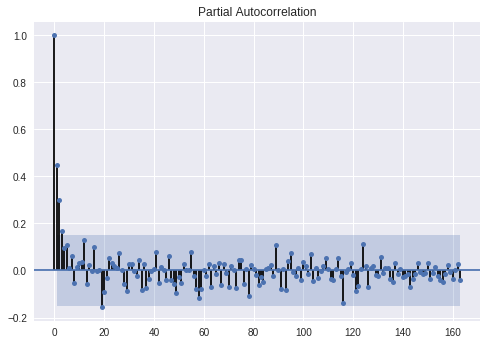

In [58]:
R2_son = R3['SON'] - f_hat_son
son2_acf = plot_acf(R2_son)
son2_pacf = plot_pacf(R2_son)

### DJF

In [59]:
robjs.globalenv['y_djf'] = robjs.FloatVector(y_djf)

robjs.globalenv["sinf_djf"] = robjs.FloatVector(sinf_djf) # Add sine to R envrionment as FloatVector
robjs.globalenv["cosf_djf"] = robjs.FloatVector(cosf_djf) # Add cose to R envrionment as FloatVector

fit_djf = nlme.gls(r.formula("y_djf ~ sinf_djf + cosf_djf"), method='ML')
print(r.summary(fit_djf))

Generalized least squares fit by maximum likelihood
  Model: y_djf ~ sinf_djf + cosf_djf 
  Data: NULL 
       AIC      BIC    logLik
  79.24677 91.64623 -35.62338

Coefficients:
                Value Std.Error   t-value p-value
(Intercept) -838.7721  427.9492 -1.959980  0.0517
sinf_djf      13.2385    8.4698  1.563015  0.1200
cosf_djf     866.2601  427.8972  2.024459  0.0446

 Correlation: 
         (Intr) snf_dj
sinf_djf -0.968       
cosf_djf -1.000  0.968

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-3.15747971 -0.53586890 -0.01772738  0.55348476  3.42291682 

Residual standard error: 0.3006758 
Degrees of freedom: 164 total; 161 residual



In [60]:
k_hat_djf = fit_djf.rx2('coefficients')  # extract fitted regression coefficients
print(k_hat_djf)
e_djf = np.array(fit_djf.rx2('residuals'))

(Intercept)    sinf_djf    cosf_djf 
 -838.77208    13.23847   866.26012 



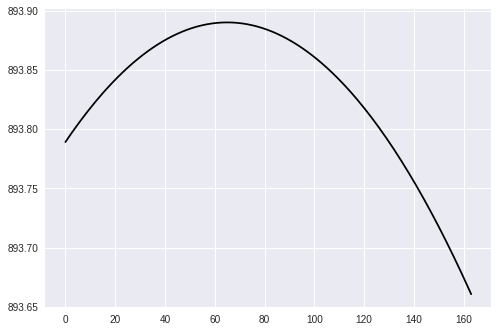

In [61]:
f_hat_djf = np.mean(y_djf) + k_hat_djf[1]*sinf_djf + k_hat_djf[2]*cosf_djf  # fitted seasonal cycle
plt.plot(f_hat_djf,'k-') 

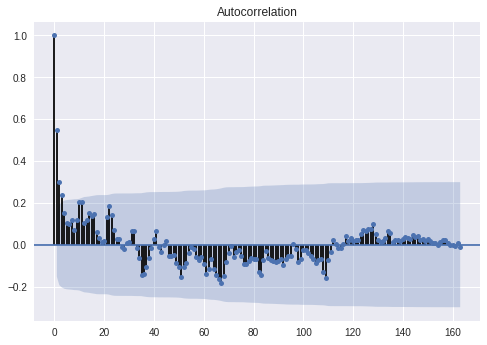

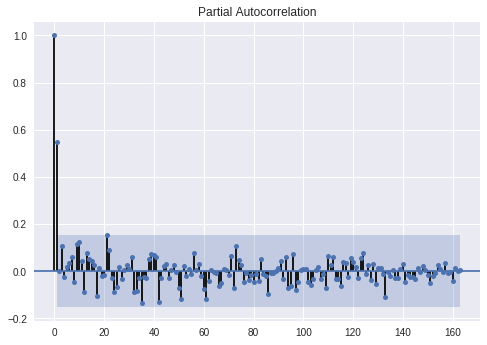

In [62]:
R2_djf = R3['DJF'] - f_hat_djf
djf2_acf = plot_acf(R2_djf)
djf2_pacf = plot_pacf(R2_djf)

### MAM

In [63]:
robjs.globalenv['y_mam'] = robjs.FloatVector(y_mam)

robjs.globalenv["sinf_mam"] = robjs.FloatVector(sinf_mam) # Add sine to R envrionment as FloatVector
robjs.globalenv["cosf_mam"] = robjs.FloatVector(cosf_mam) # Add cose to R envrionment as FloatVector

# fit regression with seasonal component and first order autoregressive covariance matrix
fit_mam = nlme.gls(r.formula("y_mam ~ sinf_mam + cosf_mam"),method='ML')
print(r.summary(fit_mam))

Generalized least squares fit by maximum likelihood
  Model: y_mam ~ sinf_mam + cosf_mam 
  Data: NULL 
       AIC      BIC    logLik
  188.6722 201.0717 -90.33611

Coefficients:
                Value Std.Error   t-value p-value
(Intercept)  67.35706 16.574452  4.063909  0.0001
sinf_mam     -3.83884  1.967779 -1.950852  0.0528
cosf_mam    -39.64734 16.501915 -2.402590  0.0174

 Correlation: 
         (Intr) snf_mm
sinf_mam -0.968       
cosf_mam -1.000  0.967

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-2.55621644 -0.63108788  0.01167041  0.62925424  2.30813217 

Residual standard error: 0.4197447 
Degrees of freedom: 164 total; 161 residual



In [64]:
k_hat_mam = fit_mam.rx2('coefficients')  # extract fitted regression coefficients
print(k_hat_mam)
e_mam = np.array(fit_mam.rx2('residuals'))

(Intercept)    sinf_mam    cosf_mam 
  67.357062   -3.838844  -39.647339 



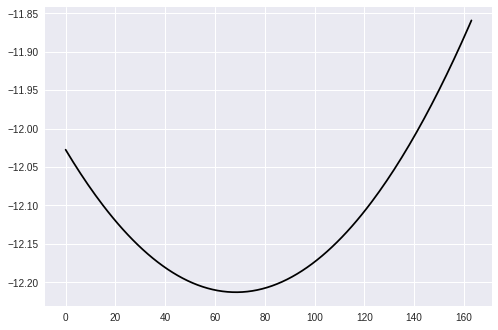

In [65]:
f_hat_mam = np.mean(y_mam) + k_hat_mam[1]*sinf_mam + k_hat_mam[2]*cosf_mam  # fitted seasonal cycle
plt.plot(f_hat_mam,'k-')

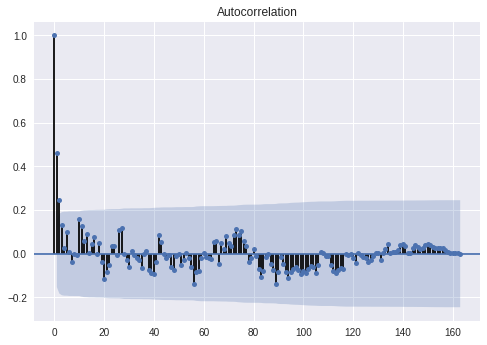

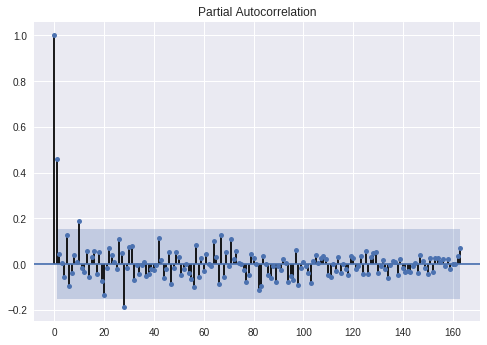

In [66]:
R2_mam = R3['MAM'] - f_hat_mam
mam2_acf = plot_acf(R2_mam)
mam2_pacf = plot_pacf(R2_mam)